<a href="https://colab.research.google.com/github/44Shu/Kaggle-Solutions/blob/main/resnet200d_fold0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Summary
Hi, Kagglers. This is a public benchmark with resnet200d using `image_size = 512`. Since it's only the beginning of the competition, I feel like giving an idea of what can be achieved with solely images. Weights are available [here](https://www.kaggle.com/underwearfitting/resnet200d-baseline-benchmark-public). Inference is available [here](https://www.kaggle.com/underwearfitting/resnet200d-public-benchmark-2xtta).

Here is the single fold training notebook. However, It cannot be run on kaggle because of the limiting computing resources. It can reach CV around 0.955 every fold and LB 0.965 in 5 folds. Notebook modified from https://www.kaggle.com/haqishen/1st-place-soluiton-code-small-ver. It's slightly different from my local version but I believe you are smart enough to figure it out.

## Configuration

In [1]:
fold_id = 0

# image_size = 512
image_size = 640
seed = 42
warmup_epo = 1
init_lr = 1e-4/3
batch_size = 8 # 64
valid_batch_size = 32
n_epochs = 30
warmup_factor = 10
num_workers = 4

use_amp = True
debug = False # change this to run on full data
early_stop = 5

kernel_type = 'resnet200d'
data_dir = '/content/data'

model_dir = f'/content/drive/MyDrive/RANSAC'
# ! mkdir $model_dir

## Imports

In [ ]:
!pip install -q pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install fsspec
!pip install gcsfs
!pip install timm

In [ ]:
!pip uninstall albumentations
!pip install albumentations

In [ ]:
# !pip install -q kaggle
!pip install kaggle --upgrade

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('gs://kds-be051e75db59530431926394e6277d3d3c119d6e395d0850c3cd0482/pytorch-image-models-master/')
import os
import time
import cv2
import PIL.Image
import random
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR 
from warmup_scheduler import GradualWarmupScheduler
import albumentations
from albumentations import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score
import seaborn as sns
from pylab import rcParams
import timm
from warnings import filterwarnings
filterwarnings("ignore")

device = torch.device('cuda')

## Download Data using Kaggle Api

In [3]:
!mkdir data
!mkdir Kaggle

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘Kaggle’: File exists


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/Kaggle'
%cd /content/Kaggle
# !kaggle competitions download -c ranzcr-clip-catheter-line-classification
!kaggle datasets download -d serigne/ranzcr-training

In [ ]:
import zipfile
with zipfile.ZipFile('/content/Kaggle/ranzcr-training.zip','r') as zip_ref:
  zip_ref.extractall('/content/data')

In [13]:
!rm *.zip

## Model

In [4]:
class RANZCRResNet200D(nn.Module):
    def __init__(self, model_name='resnet200d', out_dim=11, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if pretrained:
            pretrained_path = '/content/drive/MyDrive/RANSAC/resnet200d_ra2-bdba9bf9.pth'
            self.model.load_state_dict(torch.load(pretrained_path))
            # pretrained_path = '/content/drive/MyDrive/RANSAC/resnet200d_fold0_cv953.pth'
            # self.model.load_state_dict(torch.load(pretrained_path),map_location={'cuda:1':'cuda:0'})
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, out_dim)

    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output

## Utils

In [5]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # for faster training, but not deterministic
    
seed_everything(seed)

## Transforms

In [6]:
transforms_train = albumentations.Compose([
   albumentations.RandomResizedCrop(image_size, image_size, scale=(0.9, 1), p=1), 
   albumentations.HorizontalFlip(p=0.5),
   albumentations.ShiftScaleRotate(p=0.5),
   albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
   albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
   albumentations.CLAHE(clip_limit=(1,4), p=0.5),
   albumentations.OneOf([
       albumentations.OpticalDistortion(distort_limit=1.0),
       albumentations.GridDistortion(num_steps=5, distort_limit=1.),
       albumentations.ElasticTransform(alpha=3),
   ], p=0.2),
   albumentations.OneOf([
       albumentations.GaussNoise(var_limit=[10, 50]),
       albumentations.GaussianBlur(),
       albumentations.MotionBlur(),
       albumentations.MedianBlur(),
   ], p=0.2),
  albumentations.Resize(image_size, image_size),
  albumentations.OneOf([
      JpegCompression(),
      Downscale(scale_min=0.1, scale_max=0.15),
  ], p=0.2),
  IAAPiecewiseAffine(p=0.2),
  IAASharpen(p=0.2),
  albumentations.Cutout(max_h_size=int(image_size * 0.1), max_w_size=int(image_size * 0.1), num_holes=5, p=0.5),
  albumentations.Normalize(),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

## Dataset

In [7]:
class RANZERDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        self.labels = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row.file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image']
                
        img = img.astype(np.float32)
        img = img.transpose(2,0,1)
        label = torch.tensor(self.labels[index]).float()
        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), label

In [8]:
df_train = pd.read_csv('/content/drive/MyDrive/RANSAC train/train_5folds.csv')
df_train['file_path'] = df_train.StudyInstanceUID.apply(lambda x: os.path.join(data_dir, f'{x}.jpg'))
if debug:
    df_train = df_train.sample(frac=0.1)
target_cols = df_train.iloc[:, 1:12].columns.tolist()
dataset = RANZERDataset(df_train, 'train', transform=transforms_train)

## Utils

In [9]:
def macro_multilabel_auc(label, pred):
    aucs = []
    for i in range(len(target_cols)):
        aucs.append(roc_auc_score(label[:, i], pred[:, i]))
    print(np.round(aucs, 4))
    return np.mean(aucs)


def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):

        images, targets = images.to(device), targets.to(device)
        
        if use_amp:
            with torch.cuda.amp.autocast():
                logits = model(images)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        else:
            logits = model(images)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train = np.mean(losses)
    return loss_train


def valid_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            PREDS += [logits.sigmoid()]
            TARGETS += [targets.detach().cpu()]
            loss = criterion(logits, targets)
            losses.append(loss.item())
            smooth_loss = np.mean(losses[-30:])
            bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')
            
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    #roc_auc = roc_auc_score(TARGETS.reshape(-1), PREDS.reshape(-1))
    roc_auc = macro_multilabel_auc(TARGETS, PREDS)
    loss_valid = np.mean(losses)
    return loss_valid, roc_auc

## Training

In [10]:
model = RANZCRResNet200D(out_dim=len(target_cols), pretrained=False)
model = model.to(device)

In [11]:
model.load_state_dict(torch.load('/content/drive/MyDrive/RANSAC/resnet200d_fold0_cv953.pth', map_location='cuda:0'))

<All keys matched successfully>

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=1e-7)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

df_train_this = df_train[df_train['fold'] != fold_id]
df_valid_this = df_train[df_train['fold'] == fold_id]

dataset_train = RANZERDataset(df_train_this, 'train', transform=transforms_train)
dataset_valid = RANZERDataset(df_valid_this, 'valid', transform=transforms_valid)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [13]:
df_train['file_path'][0]

'/content/data/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg'

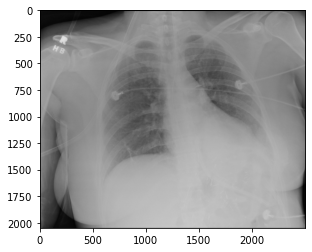

In [14]:
image = cv2.imread(df_train['file_path'][0]) 
plt.imshow(image) 
plt.show()

In [ ]:
log = {}
roc_auc_max = 0.
loss_min = 99999
not_improving = 0

for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    loss_train = train_func(train_loader)
    loss_valid, roc_auc = valid_func(valid_loader)

    log['loss_train'] = log.get('loss_train', []) + [loss_train]
    log['loss_valid'] = log.get('loss_valid', []) + [loss_valid]
    log['lr'] = log.get('lr', []) + [optimizer.param_groups[0]["lr"]]
    log['roc_auc'] = log.get('roc_auc', []) + [roc_auc]

    content = time.ctime() + ' ' + f'Fold {fold_id}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, roc_auc: {roc_auc:.6f}.'
    print(content)
    not_improving += 1
    
    if roc_auc > roc_auc_max:
        print(f'roc_auc_max ({roc_auc_max:.6f} --> {roc_auc:.6f}). Saving model ...')
        torch.save(model.state_dict(), f'{model_dir}{kernel_type}_fold{fold_id}_best_AUC.pth')
        roc_auc_max = roc_auc
        not_improving = 0

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), f'{model_dir}{kernel_type}_fold{fold_id}_best_loss.pth')
        
    if not_improving == early_stop:
        print('Early Stopping...')
        break
        
    ## only run 1 epoch here
    break

torch.save(model.state_dict(), f'{model_dir}{kernel_type}_640fold{fold_id}_final.pth')

loss: 0.24467, smth: 0.18625:  96%|█████████▌| 2883/3010 [39:32<01:48,  1.17it/s]